In [1]:
from utils.libipts import Parser

import numpy as np
import scipy.ndimage
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
%matplotlib notebook

# config
plot_size = 3.2
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (3 * plot_size, 2 * plot_size)

In [2]:
# Sobel operator kernels for gradients (1st order derivative)
SOBEL_X = np.array([
    [1.0, 0.0, -1.0],
    [2.0, 0.0, -2.0],
    [1.0, 0.0, -1.0],
])

SOBEL_Y = SOBEL_X.T

In [3]:
# Sobel operator kernels for Hessian (2nd order derivative)
SOBEL_XX = np.array([
    [1.0, -2.0, 1.0],
    [2.0, -4.0, 2.0],
    [1.0, -2.0, 1.0],
])

SOBEL_YY = SOBEL_XX.T

SOBEL_XY = np.array([
    [ 1.0, 0.0, -1.0],
    [ 0.0, 0.0,  0.0],
    [-1.0, 0.0,  1.0],
])

In [4]:
# Alternative Sobel operator kernels for Hessian (2nd order derivative)
SOBEL_XX_2 = np.array([
    [1.0, 0.0,  -2.0, 0.0, 1.0],
    [4.0, 0.0,  -8.0, 0.0, 4.0],
    [6.0, 0.0, -12.0, 0.0, 6.0],
    [4.0, 0.0,  -8.0, 0.0, 4.0],
    [1.0, 0.0,  -2.0, 0.0, 1.0],
])

SOBEL_YY_2 = SOBEL_XX_2.T

SOBEL_XY_2 = np.array([
    [ 1.0,  2.0, 0.0, -2.0, -1.0],
    [ 2.0,  4.0, 0.0, -4.0, -2.0],
    [ 0.0,  0.0, 0.0,  0.0,  0.0],
    [-2.0, -4.0, 0.0,  4.0,  2.0],
    [-1.0, -2.0, 0.0,  2.0,  1.0],
])

In [5]:
# Helper function for gradient
def gradient(img):
    vx = scipy.signal.convolve2d(img, SOBEL_X, mode='same')
    vy = scipy.signal.convolve2d(img, SOBEL_Y, mode='same')

    return np.dstack((vx, vy))

In [6]:
# Helper function for hessian
def hessian(img):
    vxx = scipy.signal.convolve2d(img, SOBEL_XX, mode='same')
    vyy = scipy.signal.convolve2d(img, SOBEL_YY, mode='same')
    vxy = scipy.signal.convolve2d(img, SOBEL_XY, mode='same')

    h = np.zeros((*img.shape, 2, 2))
    h[:, :, 0, 0] = vxx
    h[:, :, 1, 1] = vyy
    h[:, :, 0, 1] = h[:, :, 1, 0] = vxy

    return h

In [7]:
# Structure tensor
def structure_tensor(grad, sigma=1.0):
    sxx = grad[:, :, 0]**2
    syy = grad[:, :, 1]**2
    sxy = grad[:, :, 0] * grad[:, :, 1]

    sxx = scipy.ndimage.gaussian_filter(sxx, sigma)
    syy = scipy.ndimage.gaussian_filter(syy, sigma)
    sxy = scipy.ndimage.gaussian_filter(sxy, sigma)

    s = np.zeros((grad.shape[0], grad.shape[1], 2, 2))
    s[:, :, 0, 0] = sxx
    s[:, :, 1, 1] = syy
    s[:, :, 0, 1] = s[:, :, 1, 0] = sxy

    return s

In [8]:
# Smooth hessian
def smooth_hessian(hessian, sigma=1.0):
    hs = np.copy(hessian)

    hs[:, :, 0, 0] = scipy.ndimage.gaussian_filter(hs[:, :, 0, 0], sigma)
    hs[:, :, 1, 1] = scipy.ndimage.gaussian_filter(hs[:, :, 1, 1], sigma)
    hs[:, :, 0, 1] = hs[:, :, 1, 0] = scipy.ndimage.gaussian_filter(hs[:, :, 0, 1], sigma)

    return hs

In [9]:
# Parser to extract touch data
class TouchParser(Parser):
    def __init__(self):
        super().__init__()
        self.dim = None

    def _on_heatmap_dim(self, dim):
        self.dim = dim

    def _on_heatmap(self, data):
        hm = np.frombuffer(data, dtype=np.ubyte)
        hm = hm.reshape((self.dim.height, self.dim.width))
        hm = np.flip(hm, axis=0).T
        hm = (hm.astype(np.float) - self.dim.z_min) / (self.dim.z_max - self.dim.z_min)

        self.data.append(1.0 - hm)

    def parse(self, data):
        self.data = list()
        super().parse(data, silent=True)
        return np.array(self.data)

In [10]:
file = 'data/touch-sb2_13-hand-1.iptsraw'

with open(file, 'rb') as f:
    data = f.read()

heatmaps = TouchParser().parse(data)

In [11]:
def preprocess(heatmap, sigma=1.0):
    hm = scipy.ndimage.gaussian_filter(heatmap, 1.0)
    hm = np.maximum(hm - np.average(hm), 0.0)
    return hm

In [12]:
hm = heatmaps[106].T
hmpp = preprocess(hm)

g = gradient(hmpp)
h = hessian(hmpp)
s = structure_tensor(g)
hs = smooth_hessian(h)

ews_s, evs_s = np.linalg.eig(s)
ews_hs, evs_hs = np.linalg.eig(hs)

# Curvature
# Note: This is equivalent to the sum of eigenvalues (i.e. sum(ev(hs)) == trace(hs))
curv = np.trace(hs, axis1=-2, axis2=-1)

# Curvature may cancel itself out, for segmentation we're mostly interested in u shapes, i.e. positive curvature
ridge = np.sum(np.maximum(ews_hs, 0.0), axis=-1)

<IPython.core.display.Javascript object>


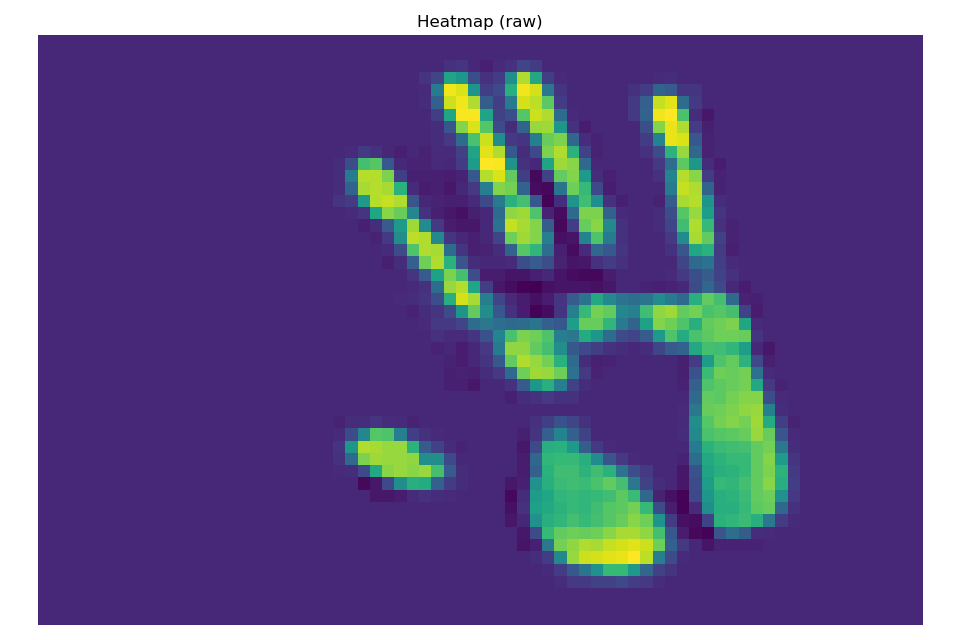

In [13]:
# visualize original heatmap
fig, ax = plt.subplots()
ax.set_title('Heatmap (raw)')
ax.axis('off')
ax.imshow(hm)
plt.show()

<IPython.core.display.Javascript object>


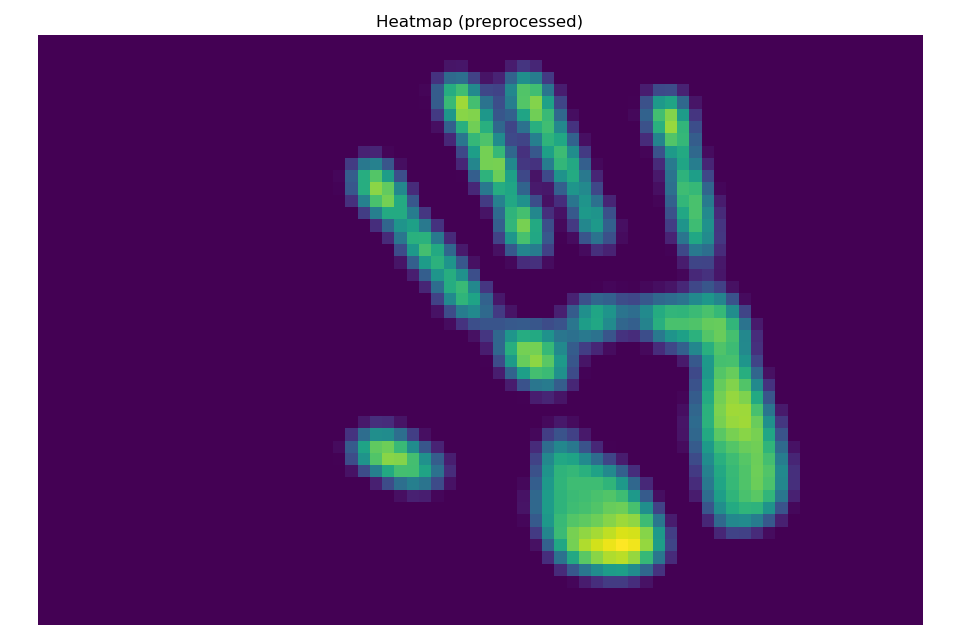

In [14]:
# visualize pre-processed heatmap
fig, ax = plt.subplots()
ax.set_title('Heatmap (preprocessed)')
ax.axis('off')
ax.imshow(hmpp)
plt.show()

<IPython.core.display.Javascript object>


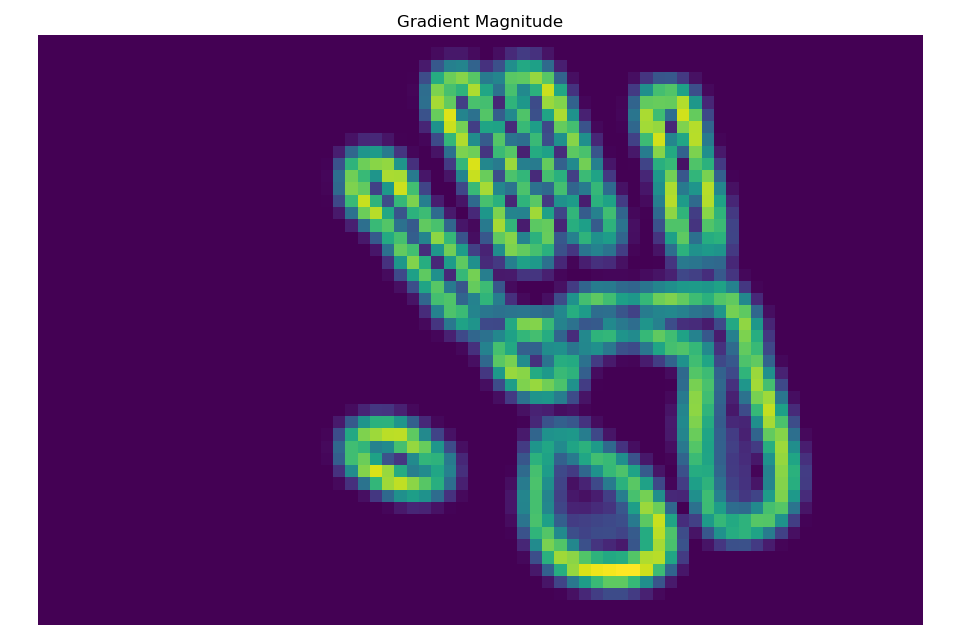

In [15]:
# visualize gradient magnitude
fig, ax = plt.subplots()
ax.set_title('Gradient Magnitude')
ax.axis('off')
ax.imshow(np.linalg.norm(g, axis=-1))
plt.show()

<IPython.core.display.Javascript object>


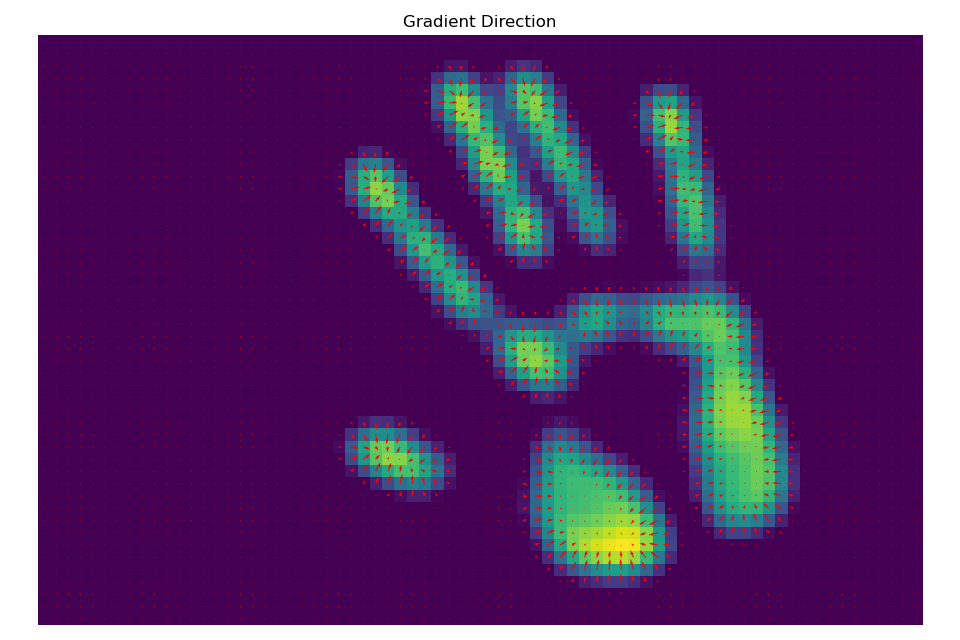

In [16]:
# visualize gradient direction
fig, ax = plt.subplots()
ax.set_title('Gradient Direction')
ax.axis('off')
ax.imshow(hmpp)
ax.quiver(g[:, :, 0], -g[:, :, 1], fc='r', ec='r', units='x', width=0.08, scale=0.8)
plt.show()

<IPython.core.display.Javascript object>


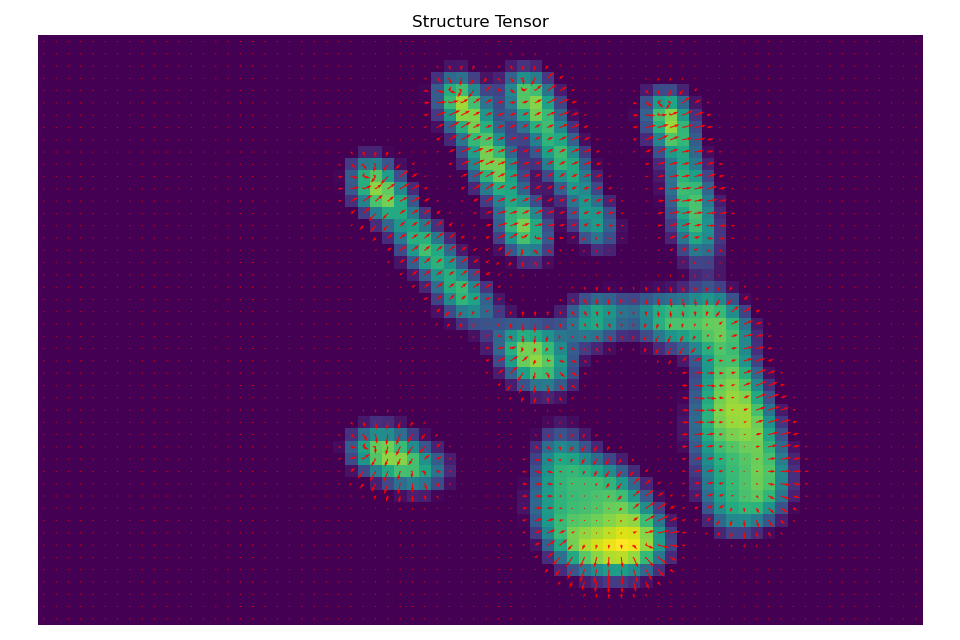

In [17]:
# visualize structure tensor
fig, ax = plt.subplots()
ax.set_title('Structure Tensor')
ax.axis('off')
ax.imshow(hmpp)
for i in range(2):
    _uv = evs_s[:, :, i, :] * ews_s[:, :, i, None]
    ax.quiver(_uv[:, :, 0], _uv[:, :, 1], fc='r', ec='r', units='x', width=0.08, scale=0.25)
plt.show()

<IPython.core.display.Javascript object>


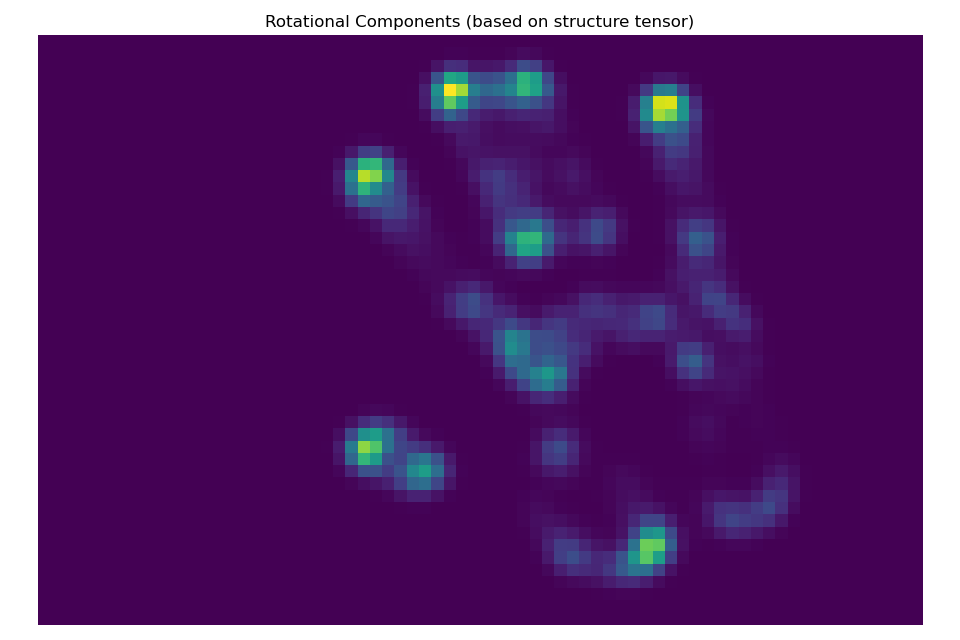

In [18]:
# visualize rotational structures
fig, ax = plt.subplots()
ax.set_title('Rotational Components (based on structure tensor)')
ax.axis('off')
ax.imshow(np.abs(np.prod(ews_s, axis=-1)))
plt.show()

<IPython.core.display.Javascript object>


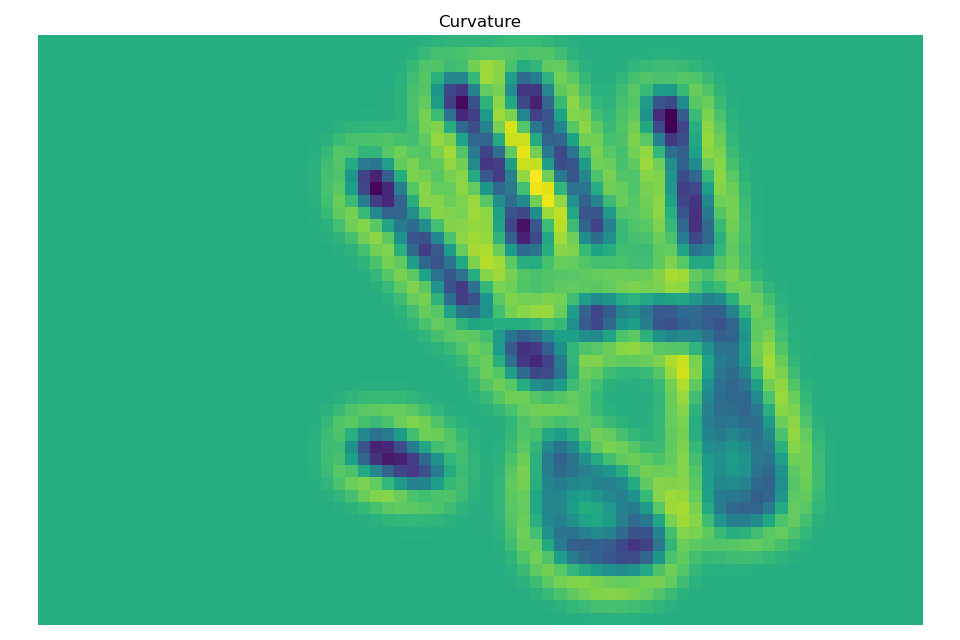

In [19]:
# visualize curvature
fig, ax = plt.subplots()
ax.set_title('Curvature')
ax.axis('off')
ax.imshow(curv)
plt.show()

<IPython.core.display.Javascript object>


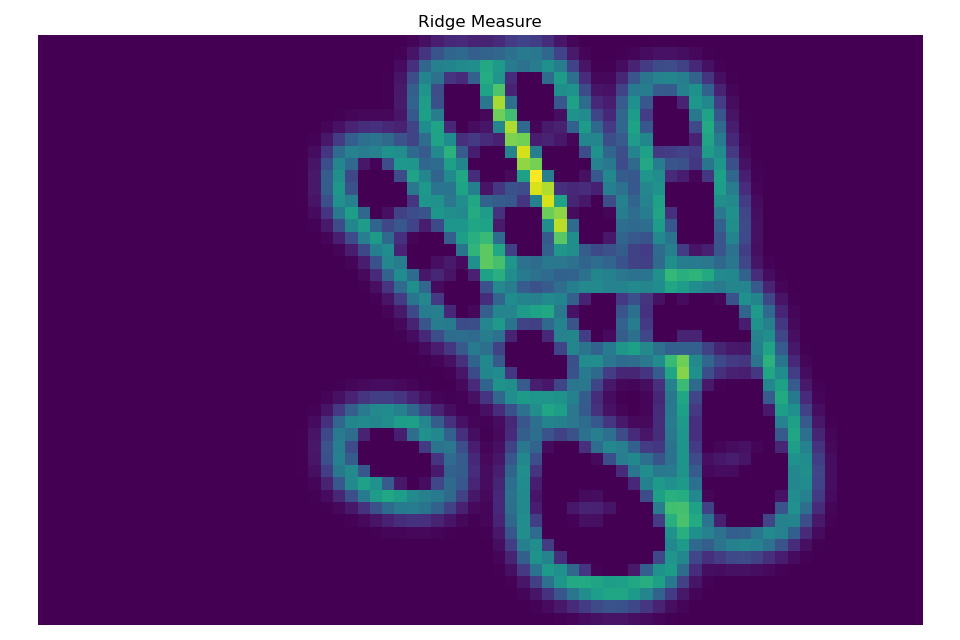

In [20]:
# visualize ridge measure
fig, ax = plt.subplots()
ax.set_title('Ridge Measure')
ax.axis('off')
ax.imshow(ridge)
plt.show()

In [21]:
# create objective function based on heatmap and ridge measure
w_ridge, p_ridge = 1.0, 1.1
w_heat, p_heat = 1.0, 1.0
th_obj = np.finfo(np.float32).eps

objective = w_heat * hmpp**p_heat - w_ridge * ridge**p_ridge
objects = objective > th_obj

In [22]:
# labeling
structure_4 = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])

structure_8 = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])

labels, num_labels = scipy.ndimage.label(objects, structure_4)

<IPython.core.display.Javascript object>


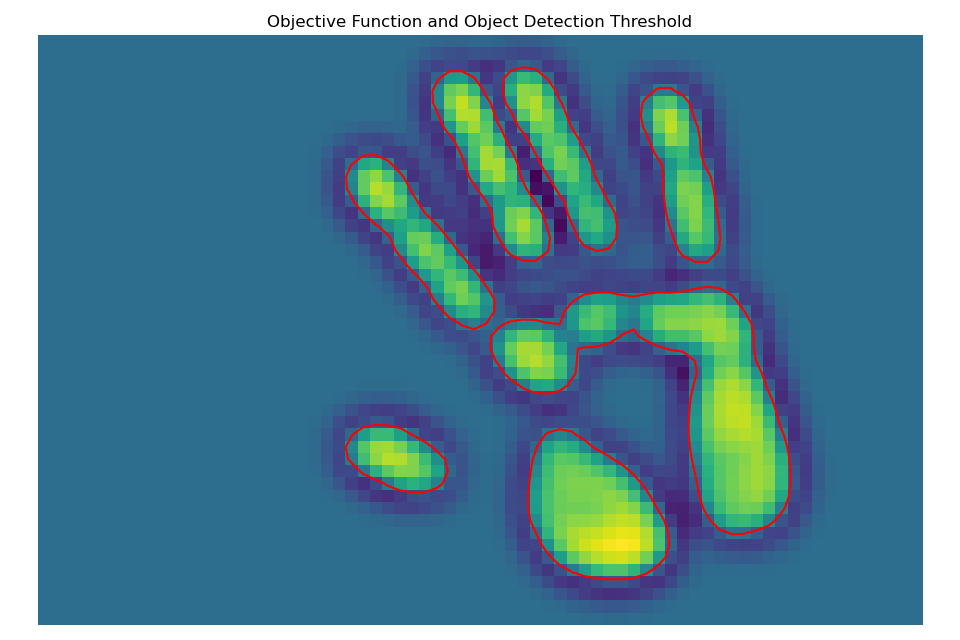

In [23]:
# visualize objective function
fig, ax = plt.subplots()
ax.set_title('Objective Function and Object Detection Threshold')
ax.axis('off')
ax.imshow(objective)
ax.contour(objective, levels=[th_obj], colors='red')
plt.show()

<IPython.core.display.Javascript object>


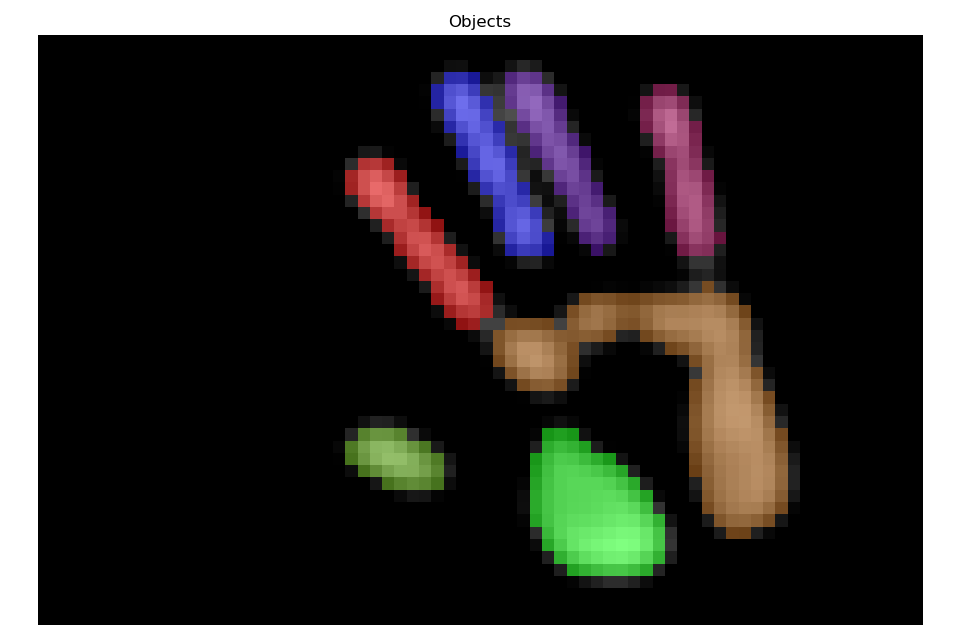

In [24]:
# visualize objects/segmentation
fig, ax = plt.subplots()
ax.set_title('Objects')
ax.axis('off')
ax.imshow(hmpp, cmap='gray')
ax.imshow(np.ma.masked_where(labels == 0, labels), alpha=0.5, cmap='brg')
plt.show()